#**Preliminaries**

In [1]:
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**Libraries**

In [2]:
# Basic packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
from zipfile import ZipFile
from tabulate import tabulate


# Machine learning packages 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#**Variables**

In [3]:
predictionHorizonMax = 15
window = 10
neurons = 50

#**Functions**

In [4]:
def SerieMatriz(timeSerie, predictionHorizonMax, window):
  timeSerie = np.squeeze(timeSerie)

  X = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, window])
  y = np.zeros([len(timeSerie)-predictionHorizonMax-window+1, predictionHorizonMax])
  for i in range(X.shape[0]):
      X[i,:] = timeSerie[i:i+window]
      y[i,:] = timeSerie[i+window: i+window+predictionHorizonMax]
  
  return X, np.squeeze(y)

#**Load data**

In [5]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

13568290/13568290 [==============================] - 0s 0us/step


In [6]:
# Import data 
df = pd.read_csv("jena_climate_2009_2016.csv")

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [8]:
data = df['max. wv (m/s)']                       # Conjunto de datos a modelar 
data = data.fillna(df['max. wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['max. wv (m/s)'] 
data.head()

max. wv (m/s)
1.75    1.75
1.50    1.50
0.63    0.63
0.50    0.50
0.63    0.63
Name: max. wv (m/s), dtype: float64

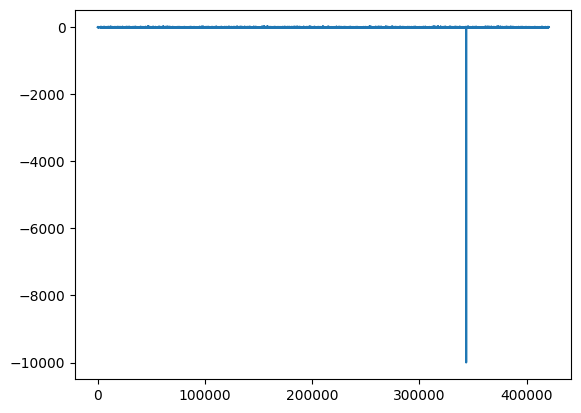

In [9]:
# Normalización de los datos 
timeSerie = data.values

plt.plot(timeSerie)
plt.show()

#**Pre-processing**

In [10]:
meanReplaced = np.mean(timeSerie[0:300000])

meanReplaced

3.5539075666666666

In [11]:
result = np.where(timeSerie<0)[0]

result

array([343577, 343578, 343579, 343580, 343581, 343582, 343583, 343584,
       343585, 343586, 343587, 343588, 343589, 343590, 343591, 343592,
       343593, 343594, 343595, 343596])

In [12]:
for i in result:
  timeSerie[i] = meanReplaced

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
time = np.arange(0, len(timeSerie),1)
timeSerieNormalized = scaler.fit_transform(timeSerie.reshape(-1,1))

X, y = SerieMatriz(timeSerieNormalized, predictionHorizonMax, window)

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape


((269136, 10, 1),
 (67285, 10, 1),
 (84106, 10, 1),
 (269136, 15),
 (67285, 15),
 (84106, 15))

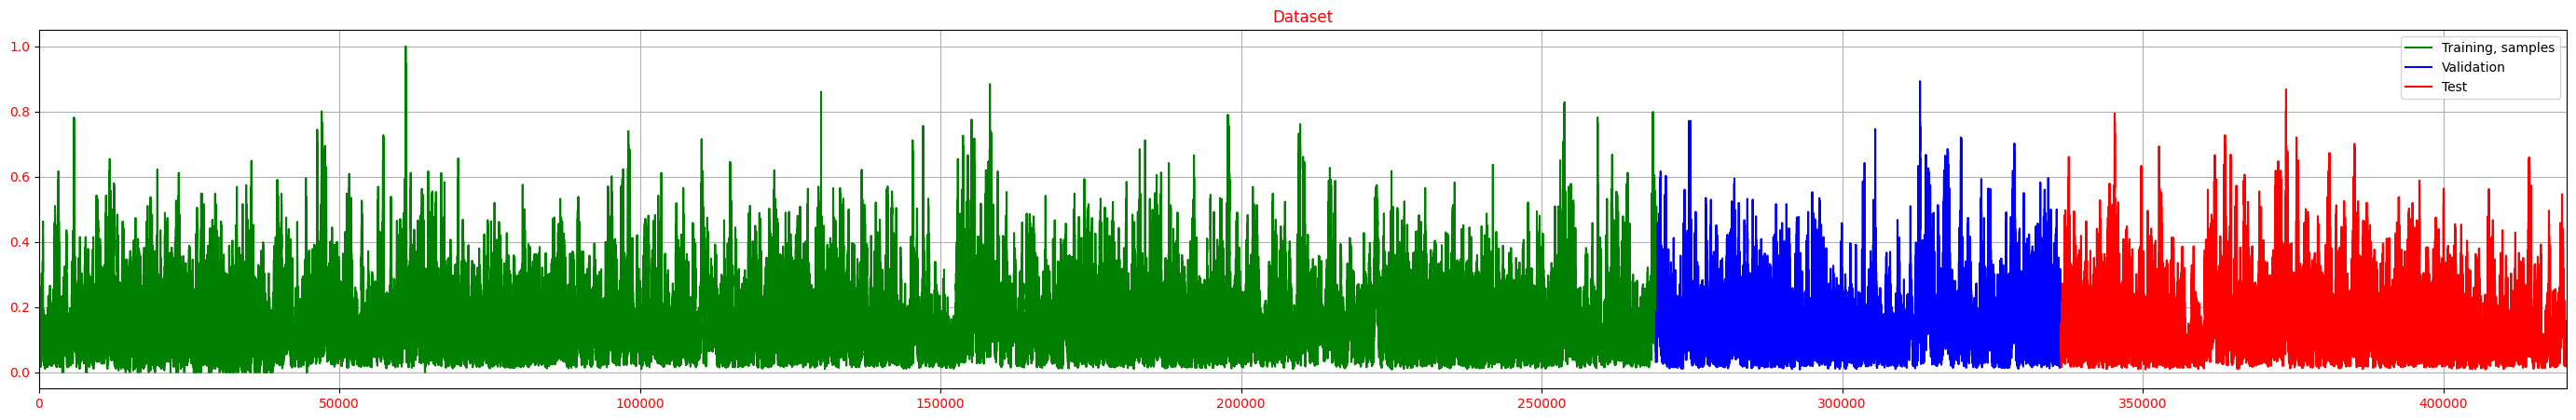

In [14]:
# Ploter el conjunto de datos 
plt.figure(figsize=(35,5))
plt.plot(time[0:X_train.shape[0]], timeSerieNormalized[0:X_train.shape[0]], 'g', label= 'Training, samples')
plt.plot(time[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], timeSerieNormalized[X_train.shape[0]:X_train.shape[0]+X_valid.shape[0]], 'b', label= 'Validation')
plt.plot(time[X_train.shape[0]+X_valid.shape[0]:], timeSerieNormalized[X_train.shape[0]+X_valid.shape[0]:], 'r', label= 'Test')
plt.title('Dataset', c='r')
plt.xticks(c='r')
plt.yticks(c='r')
plt.xlim(0,timeSerie.shape[0])
plt.legend()
plt.grid(True)
plt.show()

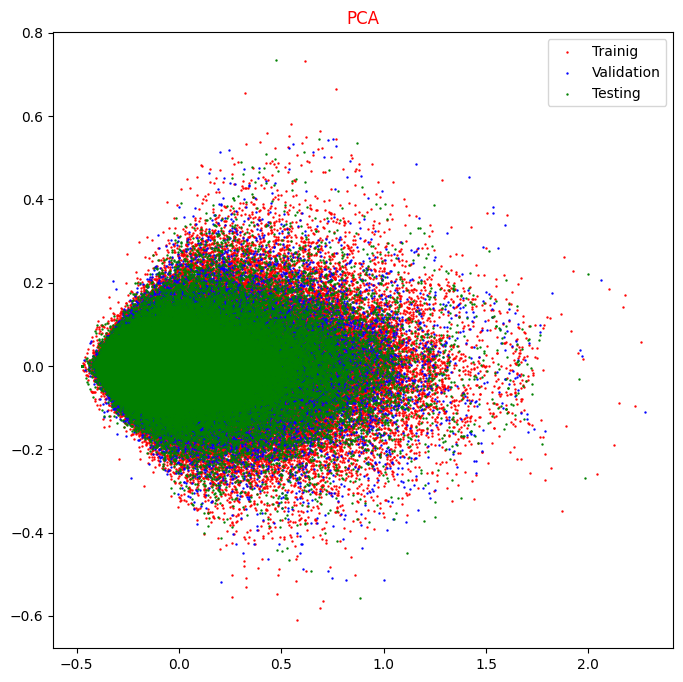

In [15]:
# Analisis exploratorio de los datos
pca = PCA(n_components = 2)
tranformed_pca_train = pca.fit_transform(np.squeeze(X_train))
tranformed_pca_valid = pca.fit_transform(np.squeeze(X_valid))
tranformed_pca_test = pca.fit_transform(np.squeeze(X_test))

plt.figure(figsize=(8, 8))
plt.title("PCA", c='r')
plt.scatter(tranformed_pca_train[:,0], tranformed_pca_train[:,1], s=0.5, c='r', label='Trainig')
plt.scatter(tranformed_pca_valid[:,0], tranformed_pca_valid[:,1], s=0.5, c='b', label='Validation')
plt.scatter(tranformed_pca_test[:,0], tranformed_pca_test[:,1], s=0.5, c='g', label='Testing')
plt.legend()
plt.show()

#**RNN simple**

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model_RNNSimple = keras.models.Sequential([
    keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(neurons, return_sequences=True),
    keras.layers.SimpleRNN(neurons),
    keras.layers.Dense(predictionHorizonMax) 
])

model_RNNSimple.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 50)          2600      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 50)          5050      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 15)                765       
                                                                 
Total params: 13,465
Trainable params: 13,465
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_RNNSimple.compile(loss="mse", 
                        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                        metrics=['mae', 'mse'])

history = model_RNNSimple.fit(X_train, y_train, epochs=100, batch_size=4096, validation_data=(X_valid, y_valid))


Epoch 1/100
66/66 [==============================] - 6s 40ms/step - loss: 0.0107 - mae: 0.0692 - mse: 0.0107 - val_loss: 0.0046 - val_mae: 0.0491 - val_mse: 0.0046
Epoch 2/100
66/66 [==============================] - 3s 40ms/step - loss: 0.0043 - mae: 0.0470 - mse: 0.0043 - val_loss: 0.0040 - val_mae: 0.0458 - val_mse: 0.0040
Epoch 3/100
66/66 [==============================] - 3s 47ms/step - loss: 0.0039 - mae: 0.0449 - mse: 0.0039 - val_loss: 0.0038 - val_mae: 0.0443 - val_mse: 0.0038
Epoch 4/100
66/66 [==============================] - 2s 34ms/step - loss: 0.0038 - mae: 0.0440 - mse: 0.0038 - val_loss: 0.0037 - val_mae: 0.0436 - val_mse: 0.0037
Epoch 5/100
66/66 [==============================] - 2s 35ms/step - loss: 0.0037 - mae: 0.0435 - mse: 0.0037 - val_loss: 0.0038 - val_mae: 0.0438 - val_mse: 0.0038
Epoch 6/100
66/66 [==============================] - 2s 34ms/step - loss: 0.0036 - mae: 0.0432 - mse: 0.0036 - val_loss: 0.0036 - val_mae: 0.0430 - val_mse: 0.0036
Epoch 7/100
66/6

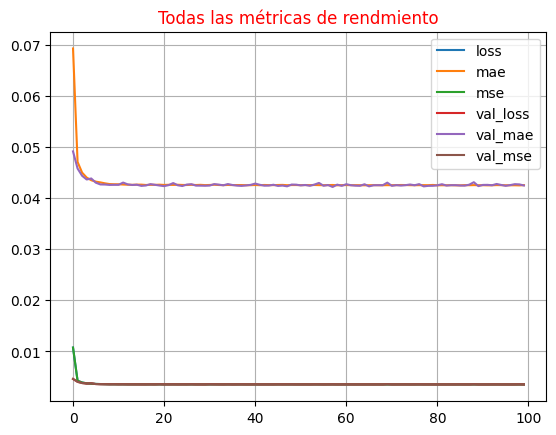

In [35]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

In [36]:
forecasting_RNNSimple = model_RNNSimple.predict(X_test)

forecasting_RNNSimple.shape

2629/2629 [==============================] - 13s 5ms/step


(84106, 15)

In [37]:
for j in range(y_test.shape[1]):
  plt.figure(figsize=(35,5))
  plt.plot(y_test[:,j], c='r', label='Target')
  plt.plot(forecasting_RNNSimple[:,j], c='b', linestyle='--', label='Forecasting')
  plt.title('Prediction horizon {j}'.format(j=j+1))
  plt.xlim(0,forecasting_RNNSimple.shape[0])
  plt.legend()
  plt.show()



Output hidden; open in https://colab.research.google.com to view.

#**GRU**

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model_GRU = keras.models.Sequential([
    keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(neurons, return_sequences=True),
    keras.layers.GRU(neurons),
    keras.layers.Dense(predictionHorizonMax) 
])

model_GRU.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, None, 50)          7950      
                                                                 
 gru_4 (GRU)                 (None, None, 50)          15300     
                                                                 
 gru_5 (GRU)                 (None, 50)                15300     
                                                                 
 dense_4 (Dense)             (None, 15)                765       
                                                                 
Total params: 39,315
Trainable params: 39,315
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_GRU.compile(loss="mse", 
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=['mae', 'mse'])

history = model_GRU.fit(X_train, y_train, epochs=100, batch_size=4096, validation_data=(X_valid, y_valid))

Epoch 1/100
66/66 [==============================] - 8s 32ms/step - loss: 0.0071 - mae: 0.0600 - mse: 0.0071 - val_loss: 0.0040 - val_mae: 0.0456 - val_mse: 0.0040
Epoch 2/100
66/66 [==============================] - 1s 22ms/step - loss: 0.0039 - mae: 0.0450 - mse: 0.0039 - val_loss: 0.0038 - val_mae: 0.0445 - val_mse: 0.0038
Epoch 3/100
66/66 [==============================] - 1s 20ms/step - loss: 0.0037 - mae: 0.0441 - mse: 0.0037 - val_loss: 0.0037 - val_mae: 0.0438 - val_mse: 0.0037
Epoch 4/100
66/66 [==============================] - 1s 18ms/step - loss: 0.0037 - mae: 0.0435 - mse: 0.0037 - val_loss: 0.0036 - val_mae: 0.0432 - val_mse: 0.0036
Epoch 5/100
66/66 [==============================] - 1s 18ms/step - loss: 0.0036 - mae: 0.0431 - mse: 0.0036 - val_loss: 0.0036 - val_mae: 0.0429 - val_mse: 0.0036
Epoch 6/100
66/66 [==============================] - 1s 19ms/step - loss: 0.0036 - mae: 0.0429 - mse: 0.0036 - val_loss: 0.0036 - val_mae: 0.0427 - val_mse: 0.0036
Epoch 7/100
66/6

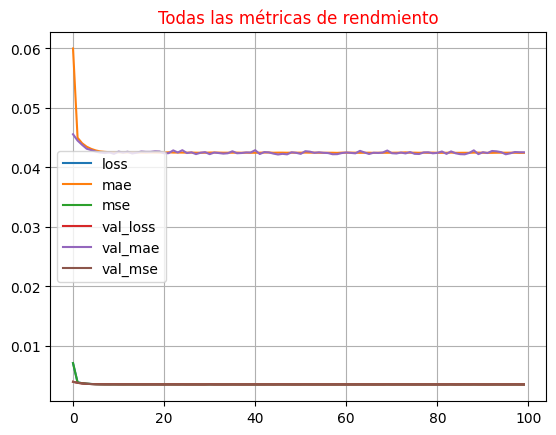

In [40]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

In [41]:
forecasting_GRU = model_GRU.predict(X_test)

forecasting_GRU.shape

2629/2629 [==============================] - 9s 3ms/step


(84106, 15)

In [42]:
for j in range(y_test.shape[1]):
  plt.figure(figsize=(35,5))
  plt.plot(y_test[:,j], c='r', label='Target')
  plt.plot(forecasting_GRU[:,j], c='b', linestyle='--', label='Forecasting')
  plt.title('Prediction horizon {j}'.format(j=j+1))
  plt.xlim(0,forecasting_GRU.shape[0])
  plt.legend()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

#**LSTM**

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = keras.models.Sequential([
    keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(neurons, return_sequences=True),
    keras.layers.LSTM(neurons),
    keras.layers.Dense(predictionHorizonMax) 
])

model_LSTM.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 50)          10400     
                                                                 
 lstm_4 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 15)                765       
                                                                 
Total params: 51,565
Trainable params: 51,565
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_LSTM.compile(loss="mse", 
                   optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   metrics=['mae', 'mse'])

history = model_LSTM.fit(X_train, y_train, epochs=100, batch_size=4096, validation_data=(X_valid, y_valid))

Epoch 1/100
66/66 [==============================] - 8s 39ms/step - loss: 0.0087 - mae: 0.0672 - mse: 0.0087 - val_loss: 0.0046 - val_mae: 0.0497 - val_mse: 0.0046
Epoch 2/100
66/66 [==============================] - 1s 20ms/step - loss: 0.0045 - mae: 0.0491 - mse: 0.0045 - val_loss: 0.0045 - val_mae: 0.0490 - val_mse: 0.0045
Epoch 3/100
66/66 [==============================] - 1s 18ms/step - loss: 0.0044 - mae: 0.0483 - mse: 0.0044 - val_loss: 0.0043 - val_mae: 0.0479 - val_mse: 0.0043
Epoch 4/100
66/66 [==============================] - 1s 18ms/step - loss: 0.0042 - mae: 0.0472 - mse: 0.0042 - val_loss: 0.0041 - val_mae: 0.0464 - val_mse: 0.0041
Epoch 5/100
66/66 [==============================] - 1s 19ms/step - loss: 0.0040 - mae: 0.0457 - mse: 0.0040 - val_loss: 0.0039 - val_mae: 0.0454 - val_mse: 0.0039
Epoch 6/100
66/66 [==============================] - 1s 19ms/step - loss: 0.0039 - mae: 0.0451 - mse: 0.0039 - val_loss: 0.0038 - val_mae: 0.0448 - val_mse: 0.0038
Epoch 7/100
66/6

In [45]:
forecasting_LSTM = model_LSTM.predict(X_test)

forecasting_LSTM.shape

2629/2629 [==============================] - 9s 3ms/step


(84106, 15)

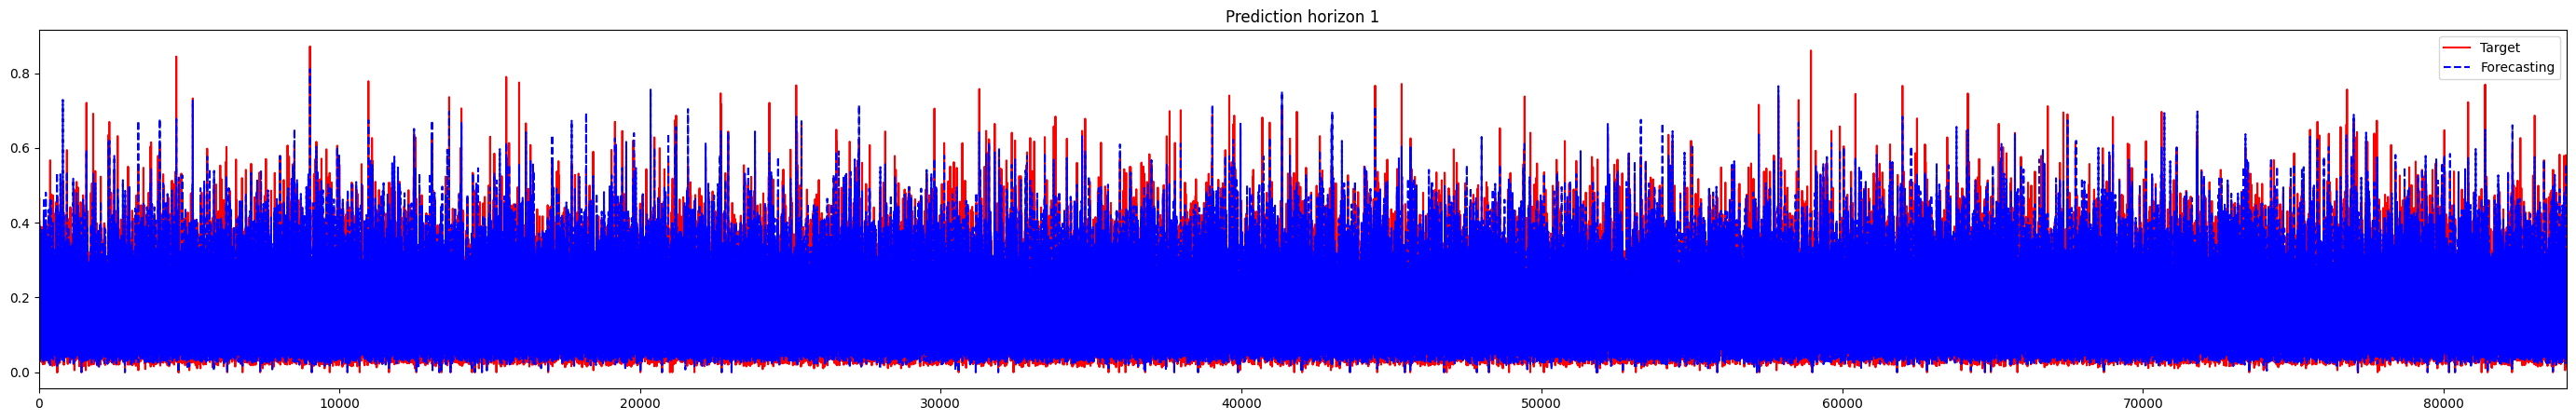

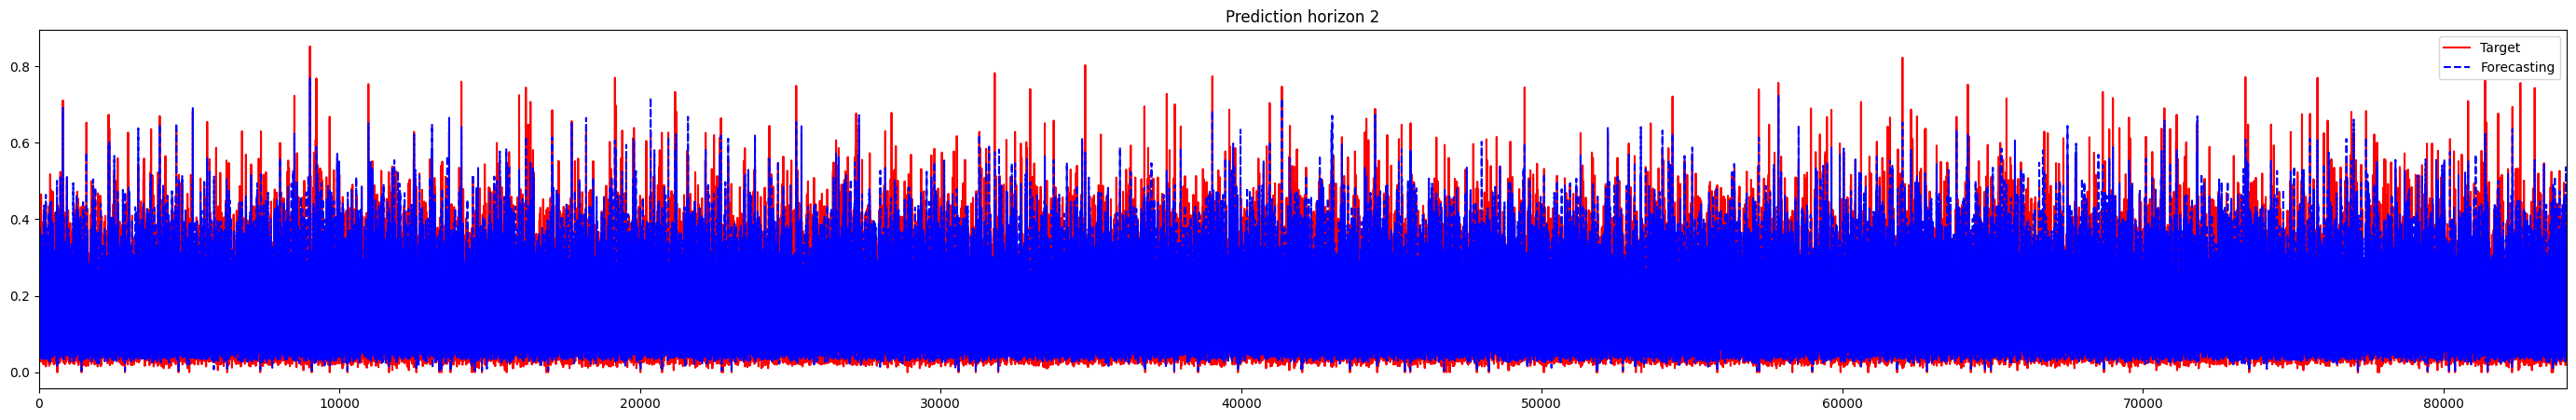

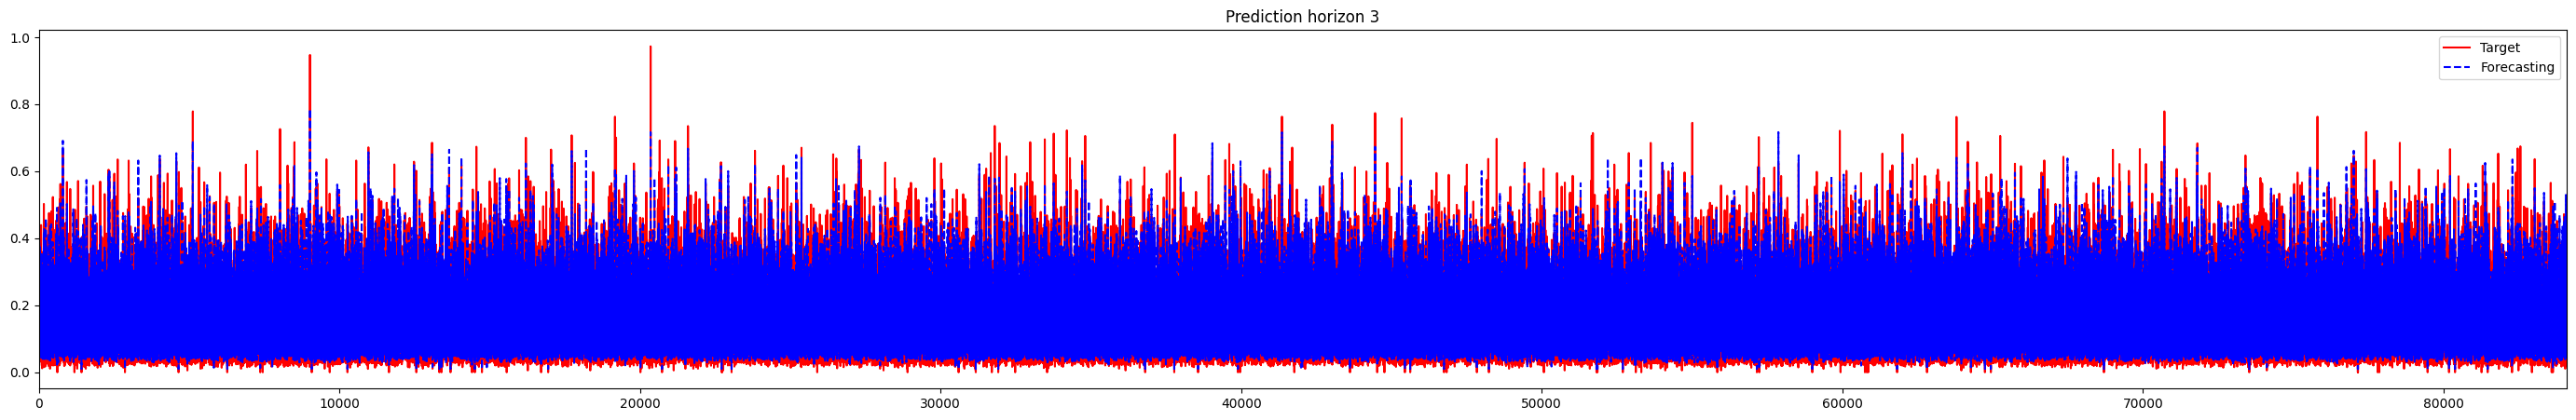

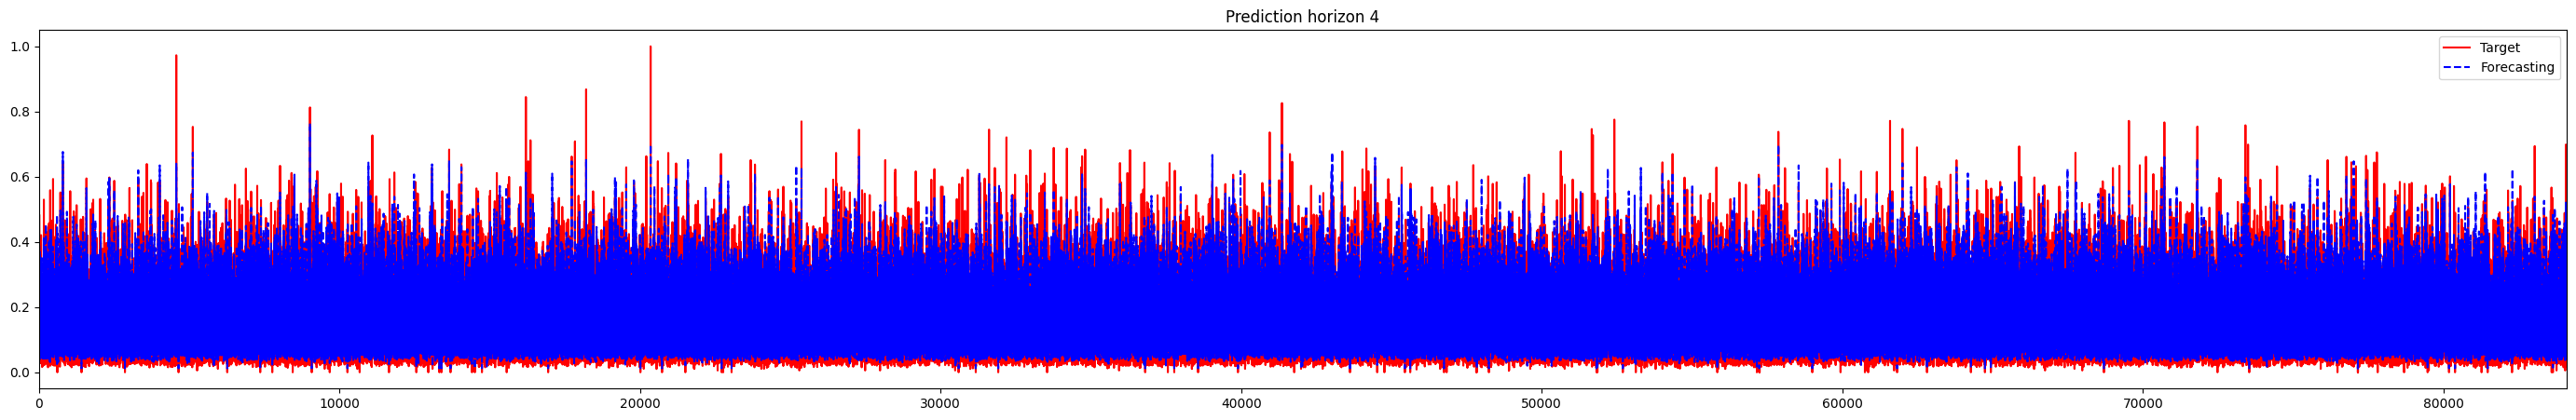

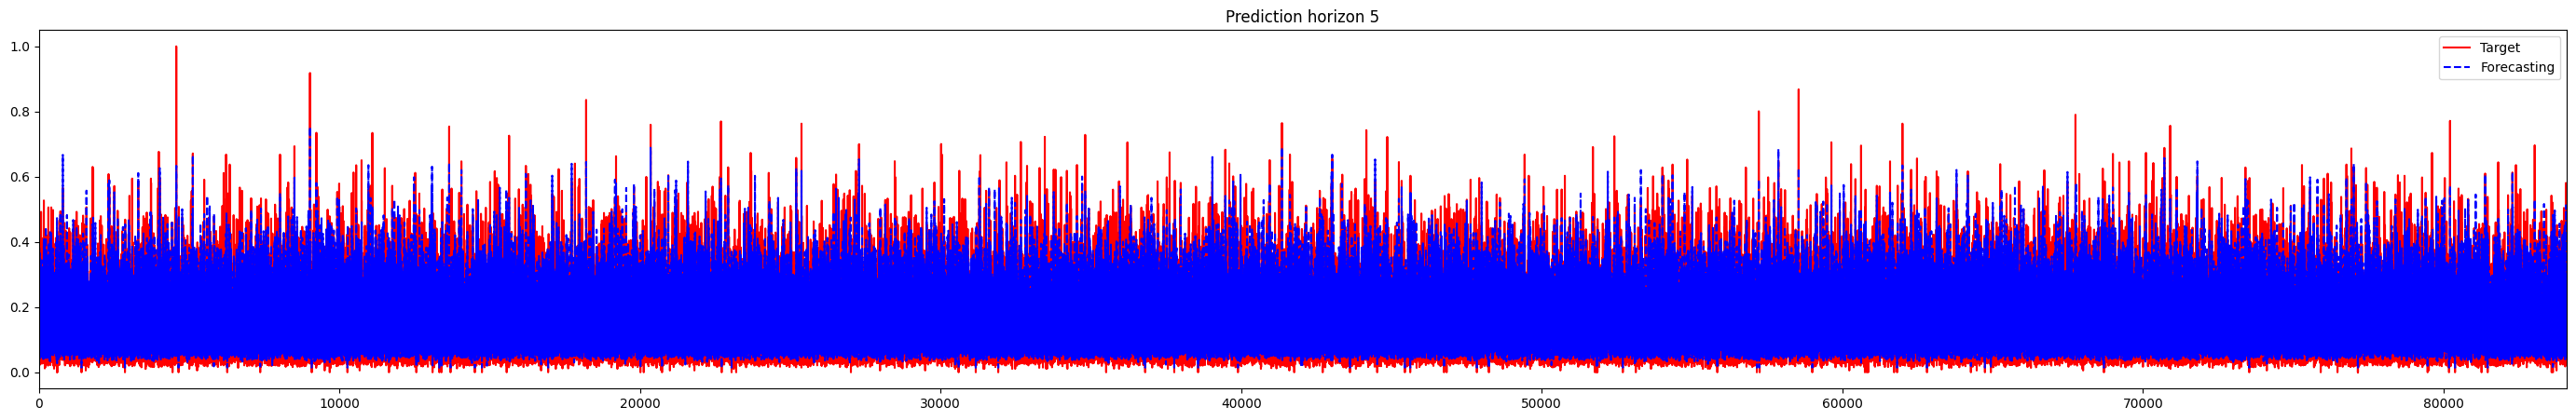

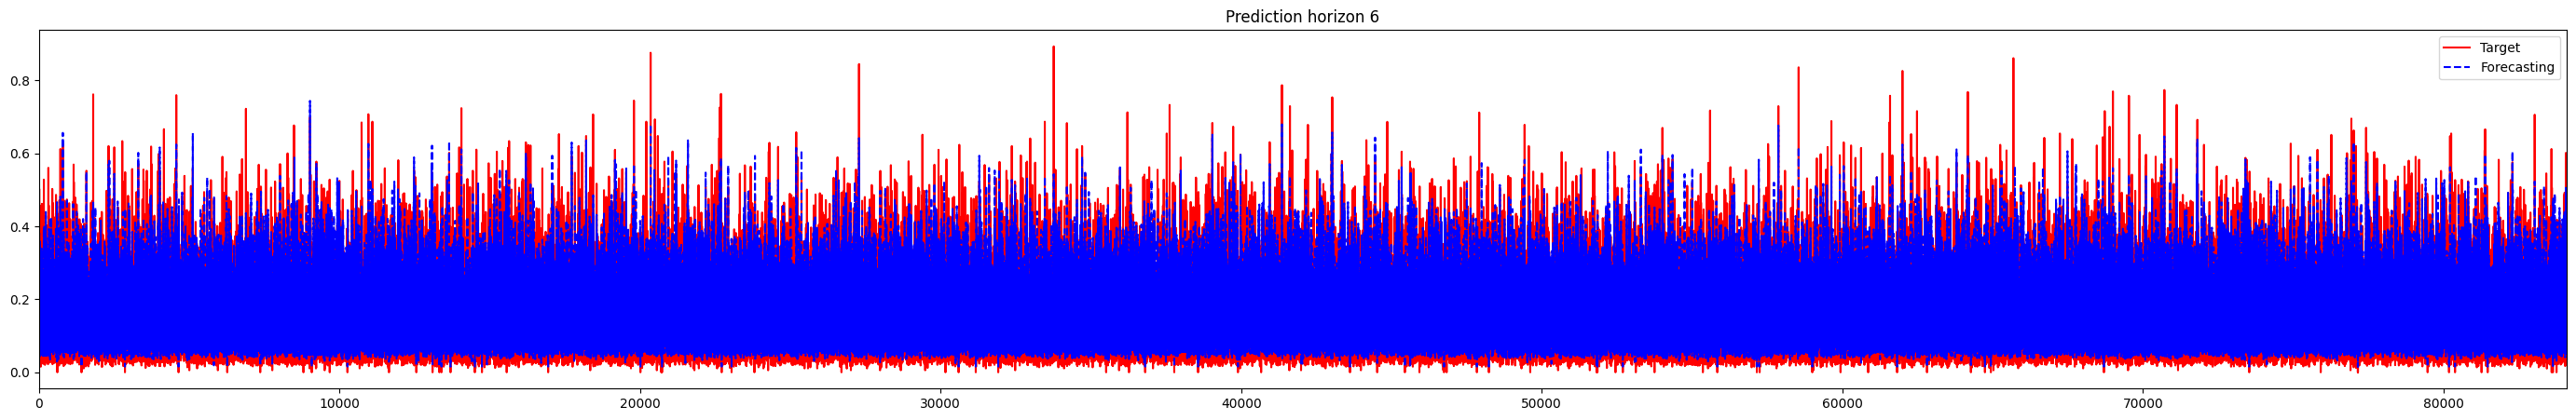

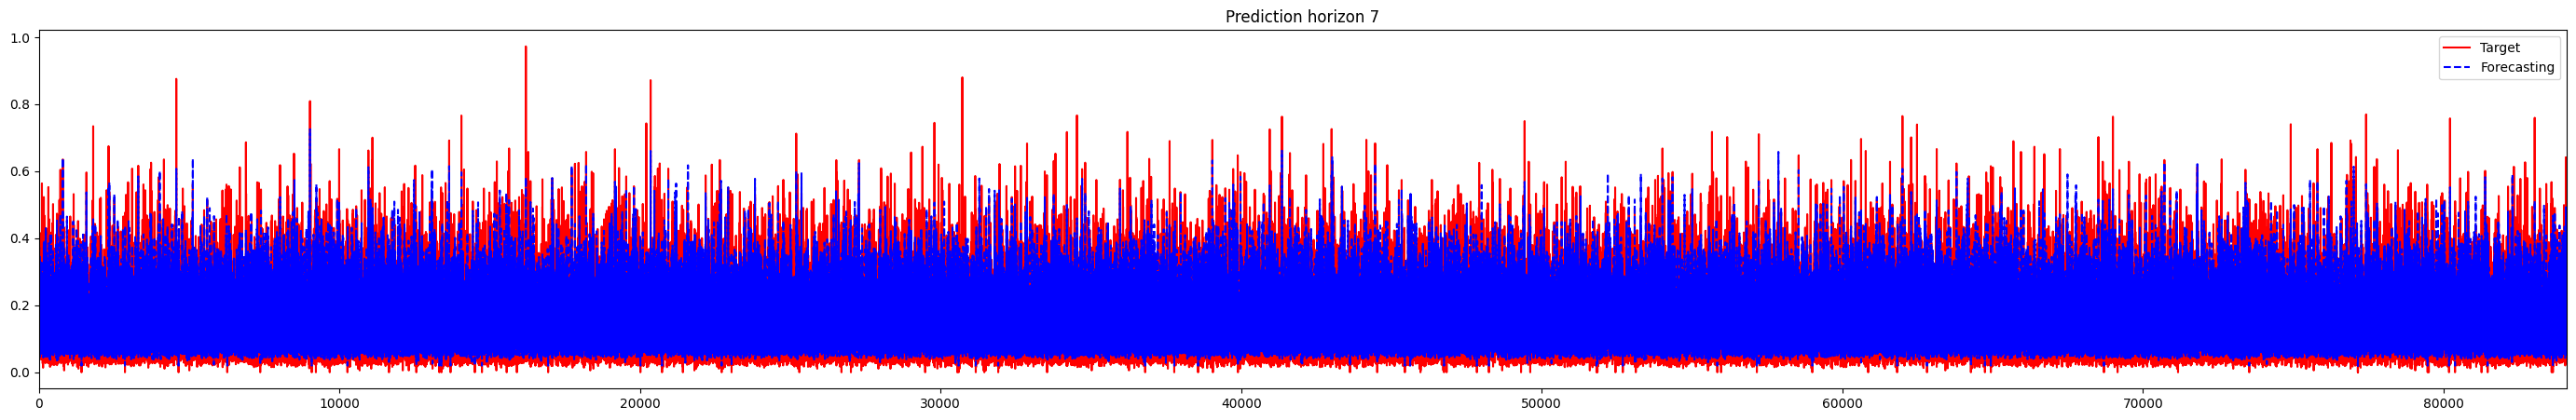

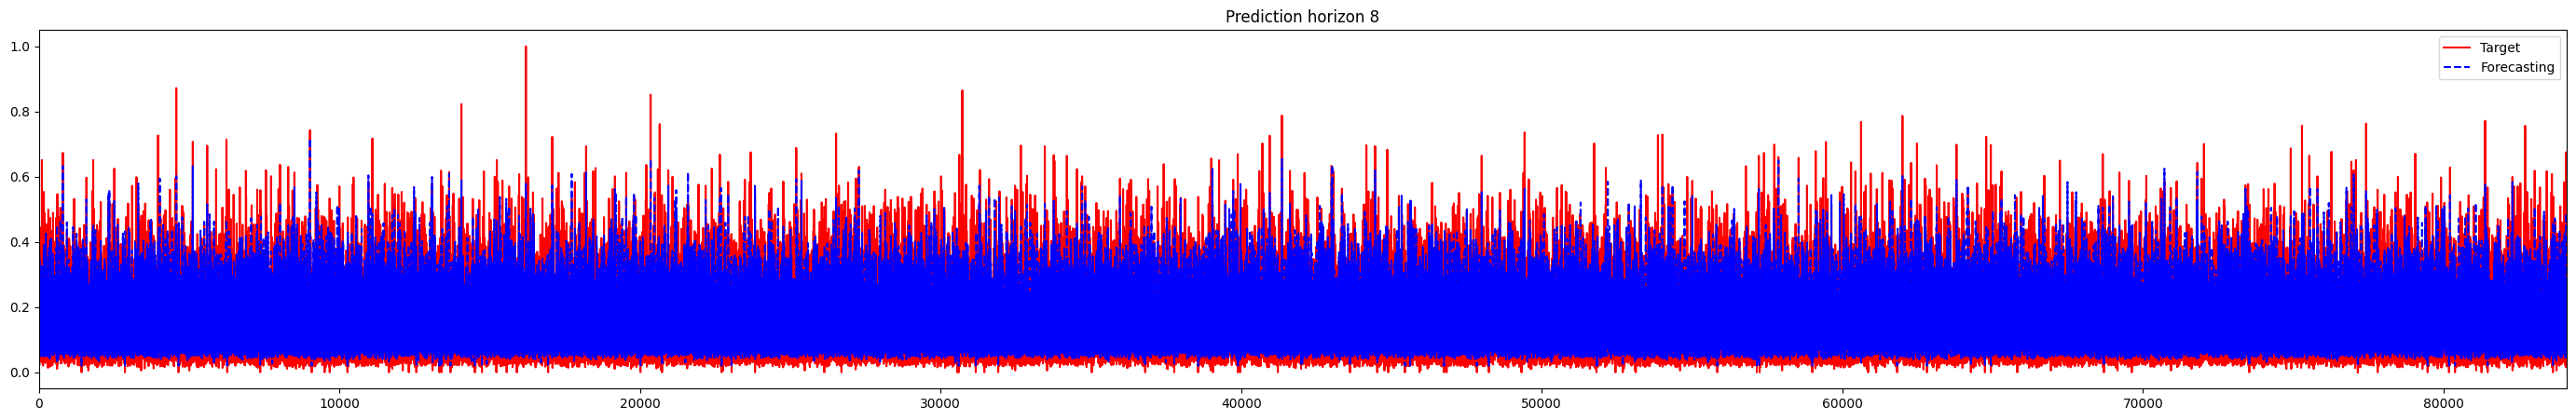

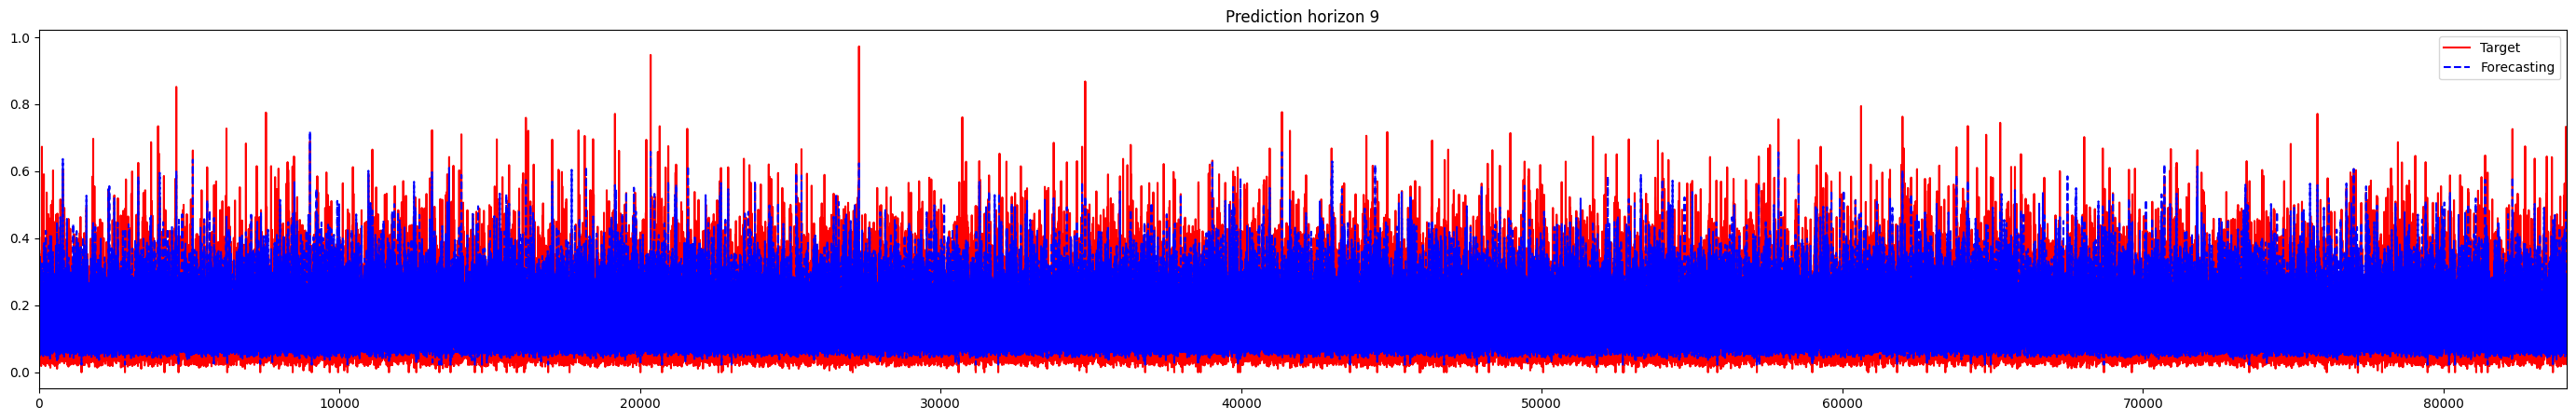

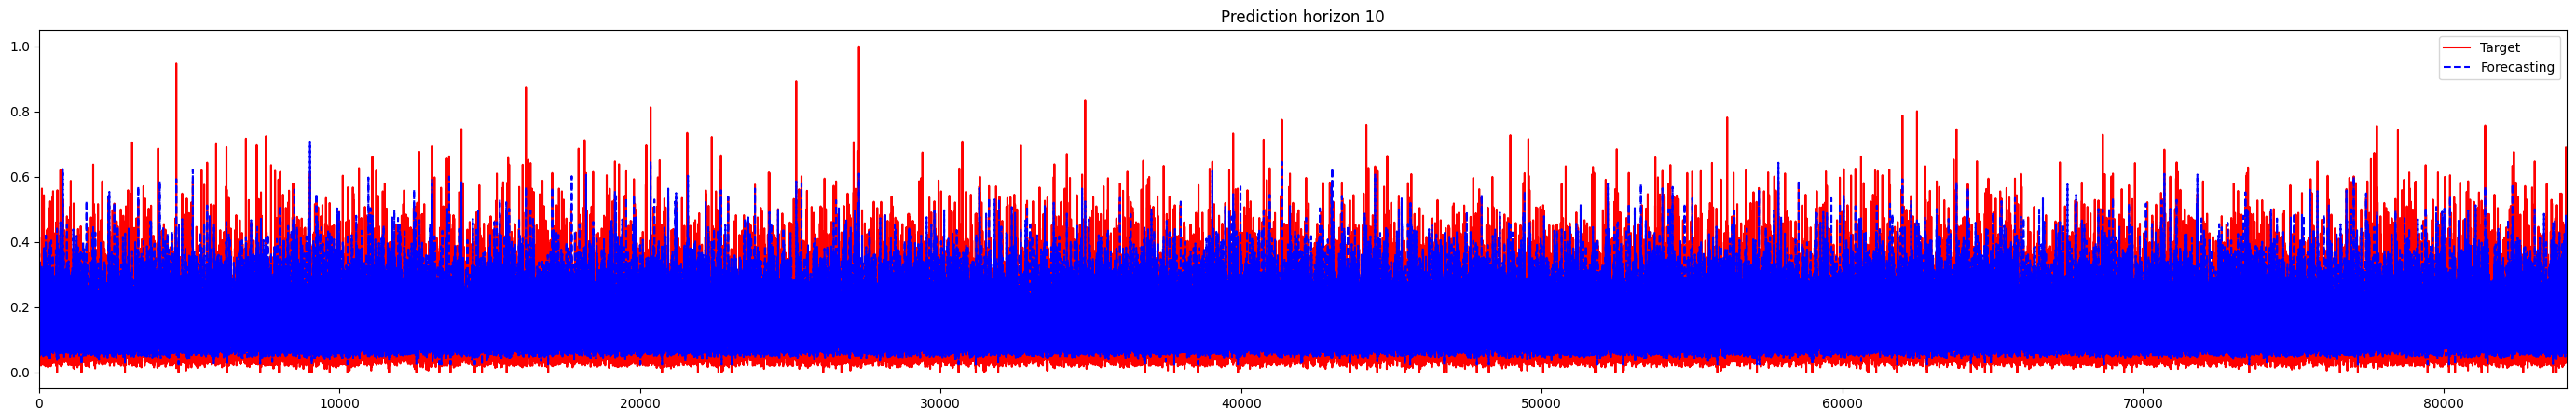

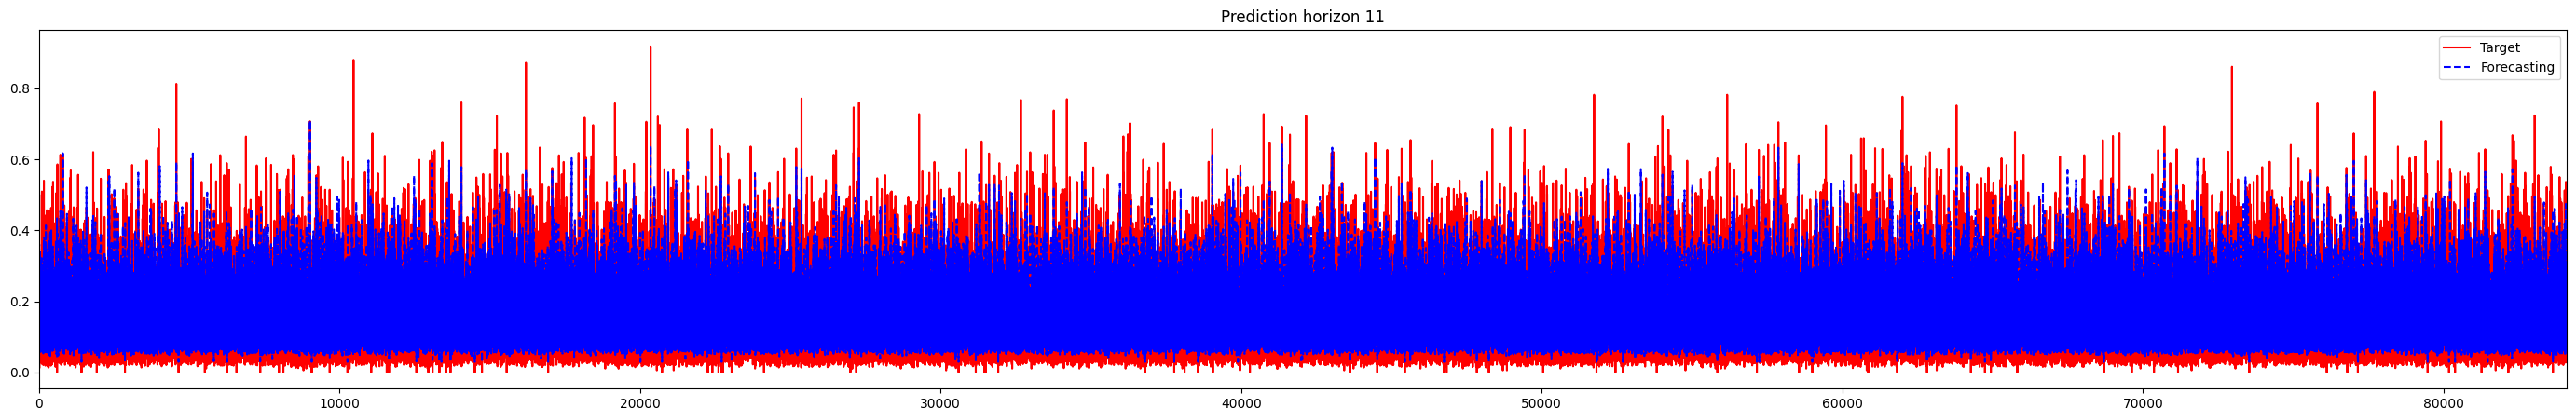

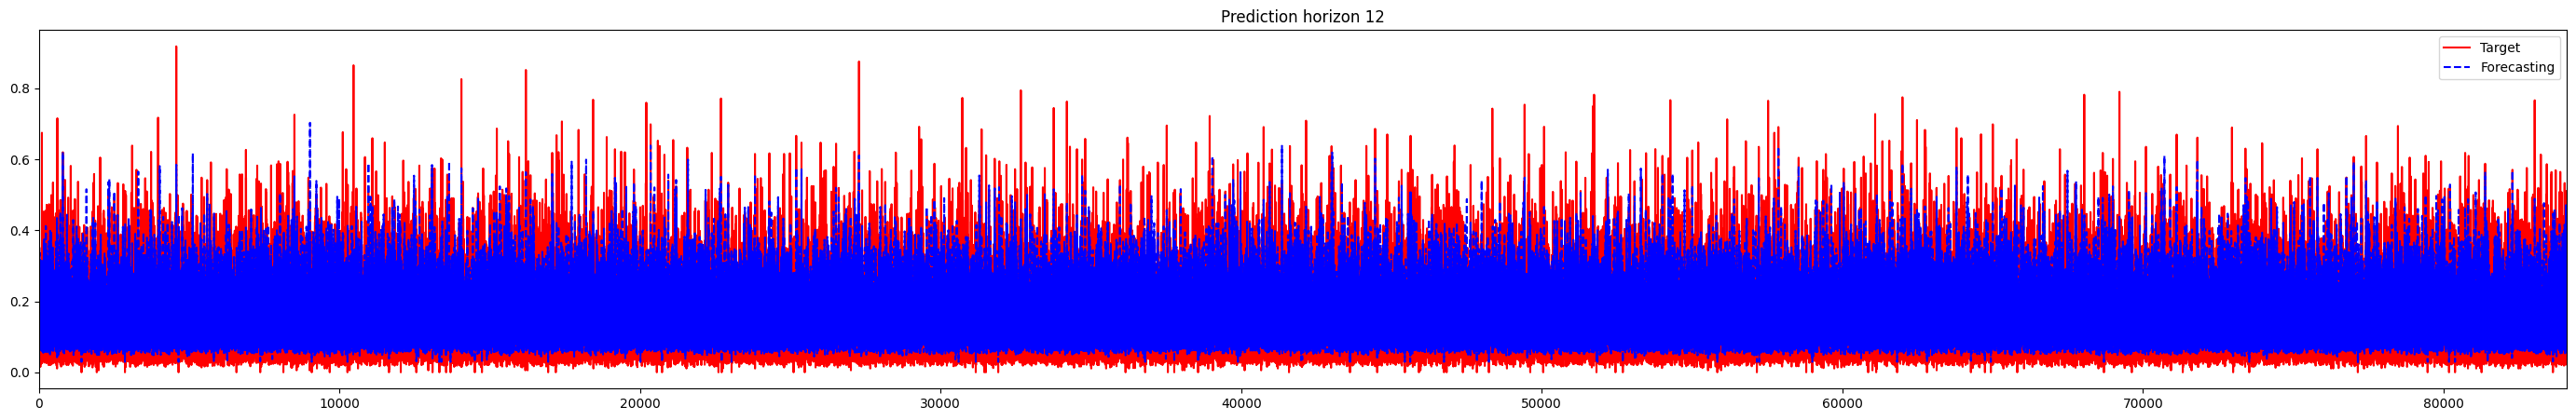

In [ ]:
for j in range(y_test.shape[1]):
  plt.figure(figsize=(35,5))
  plt.plot(y_test[:,j], c='r', label='Target')
  plt.plot(forecasting_LSTM[:,j], c='b', linestyle='--', label='Forecasting')
  plt.title('Prediction horizon {j}'.format(j=j+1))
  plt.xlim(0,forecasting_LSTM.shape[0])
  plt.legend()
  plt.show()

#**Results**

**RNN Simple**

In [ ]:
col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

for k in range(predictionHorizonMax):
  col_names.append(str(k+1))
  MSE.append(round(mean_squared_error(y_test[:,k], forecasting_RNNSimple[:,k], squared=False), 3))
  RMSE.append(round(mean_squared_error(y_test[:,k], forecasting_RNNSimple[:,k], squared=True), 3))
  MAE.append(round(mean_absolute_error(y_test[:,k], forecasting_RNNSimple[:,k]), 3))
  R2.append(round(r2_score(y_test[:,k], forecasting_RNNSimple[:,k]), 3))

data = [MSE, RMSE, MAE, R2]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

**GRU**

In [ ]:
col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

for k in range(predictionHorizonMax):
  col_names.append(str(k+1))
  MSE.append(round(mean_squared_error(y_test[:,k], forecasting_GRU[:,k], squared=False), 3))
  RMSE.append(round(mean_squared_error(y_test[:,k], forecasting_GRU[:,k], squared=True), 3))
  MAE.append(round(mean_absolute_error(y_test[:,k], forecasting_GRU[:,k]), 3))
  R2.append(round(r2_score(y_test[:,k], forecasting_GRU[:,k]), 3))

data = [MSE, RMSE, MAE, R2]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

**LSTM**

In [ ]:
col_names, MSE, RMSE, MAE, R2 = ['Metrics'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

for k in range(predictionHorizonMax):
  col_names.append(str(k+1))
  MSE.append(round(mean_squared_error(y_test[:,k], forecasting_LSTM[:,k], squared=False), 3))
  RMSE.append(round(mean_squared_error(y_test[:,k], forecasting_LSTM[:,k], squared=True), 3))
  MAE.append(round(mean_absolute_error(y_test[:,k], forecasting_LSTM[:,k]), 3))
  R2.append(round(r2_score(y_test[:,k], forecasting_LSTM[:,k]), 3))

data = [MSE, RMSE, MAE, R2]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))